In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 1


(1000,)


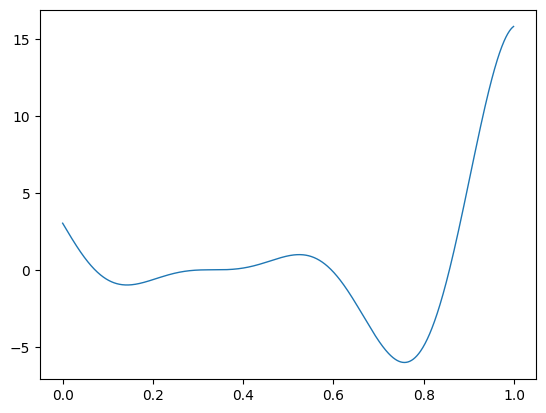

(1000, 1)


In [2]:
# Load Forrester model

Forrester_Data = BB_Model('Forrester')

#Forrester_Data.df().head()

In [3]:
Forrester_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.2950998050006727


MLPRegressor(random_state=RandomState(MT19937) at 0x2272A949840)

In [4]:
Forrester_Data.Random_Forest()

0.9999618554538072


RandomForestRegressor(random_state=RandomState(MT19937) at 0x2272A949840)

In [5]:
Forrester_Data.GP()

0.9949770272129707


GaussianProcessRegressor()

In [6]:
print(Forrester_Data.get_features())

['X']


In [7]:
#Default settings
from unravel.tabular import UnRAVELTabularExplainer

X_train, X_test, y_train, y_test = Forrester_Data.get_TT_data()

#Initializing the explainer object
Unravel_Exp = UnRAVELTabularExplainer(bbox_model           = Forrester_Data.get_GP(),
                                      train_data           = X_train,
                                      categorical_features = Forrester_Data.get_catagorical(),
                                      mode                 = Forrester_Data.get_mode())

sur_GP = Surrogate_GP()


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [8]:
#Default settings
#from unravel_2.ur_model import UR_Model

#X_train, X_test, y_train, y_test = Forrester_Data.get_TT_data()


##Initializing the explainer object
#Unravel_Exp = UR_Model(bbox_model           = Forrester_Data.get_Random_Forest(),
#                       train_data           = X_train,
#                       categorical_features = Forrester_Data.get_catagorical(),
#                       mode                 = Forrester_Data.get_mode())       


In [9]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [0.49557875]
Std 0:  [0.28748676]


In [10]:
#for i in range(5):
#    print(X_test[i,:])

In [11]:
#from matplotlib import pyplot
#pyplot.boxplot(x=X_test)
#pyplot.show()

In [12]:
# Generate explantion data for Random Forest

Forrester_Stats = Feature_Statistics(feature_names = Forrester_Data.get_features(), mode = Forrester_Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
#    data_row  = np.array([X_test[test_instance]])
    data_row  = np.array([0.4])
    
    #scores, acq_data = Unravel_Exp.explain(X_init            = data_row.reshape(1, -1),
    scores = Unravel_Exp.explain(X_init            = data_row.reshape(1, -1),
                                           feature_names     = Forrester_Data.get_features(),
                                           alpha             = "FUR",
                                           max_iter          = 20,
                                           normalize         = False,
                                           interval          = 1,
                                           importance_method = "ARD")
       
    f_predict = Forrester_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    #e_predict = Unravel_Exp.gpmodel_predict(data_row)
    #e_predict = np.array(e_predict).ravel()
    
    acq_data = Unravel_Exp.get_acq_data()
    
    X, y = Unravel_Exp.get_surrogate_data()

    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(Unravel_Exp.get_surrogate_data())

    print(f_predict, e_predict)
    
    Forrester_Stats.Add_Sample(sample_scores = scores,
                               outcome       = y_test[test_instance],
                               X_row         = data_row,
                               f_prediction  = f_predict,
                               e_prediction  = e_predict.ravel(),
                               feopt         = acq_data.get_fe_x0(),
                               model         = Unravel_Exp.get_gpmodel())


INSTANCE:  0
[4.18731689e-01 1.00000004e-05]
[0.11547747] [4.18731689e-01 1.00000004e-05]


In [13]:
import matplotlib.pyplot as plt


In [14]:
print(f_predict)
print(e_predict)


[0.11547747]
[4.18731689e-01 1.00000004e-05]


In [15]:
Forrester_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           0.3825635948471001  :  0.0  :  0.3825635948471001
y - exp(x):          0.6858178180274186  :  0.0  :  0.6858178180274186
BB(x) - exp(x):      0.30325422318031847  :  0.0  :  0.30325422318031847
Average exp(x) var:  1.0000000413701846e-05


In [16]:
#Forrester_Stats.Jaccard_Values()

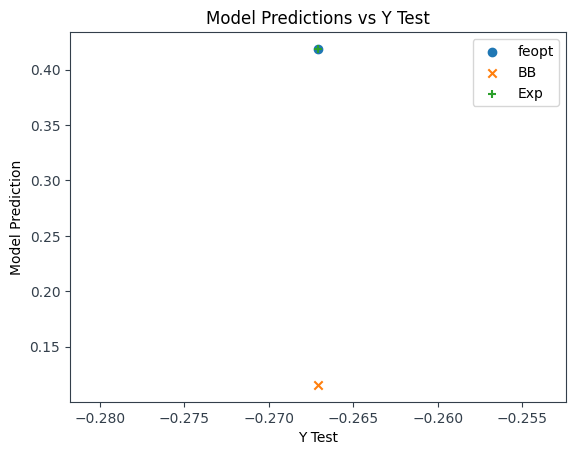

In [17]:
Forrester_Stats.Reg_Fidelity_Graph()

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF

X, y = Unravel_Exp.get_surrogate_data()
kernel = Matern()

GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10, optimizer='fmin_l_bfgs_b', normalize_y = False, copy_X_train=True)
GP.fit(X, y)
        
print(y[0])
fe = GP.predict(X[0].reshape(1,-1))
print(fe)
ey = Unravel_Exp.gpmodel_predict(X[0].reshape(1,-1))
print(ey)


[0.41873169]
[0.41873169]
(array([[0.4844553]]), array([[6.84542473e-05]]))


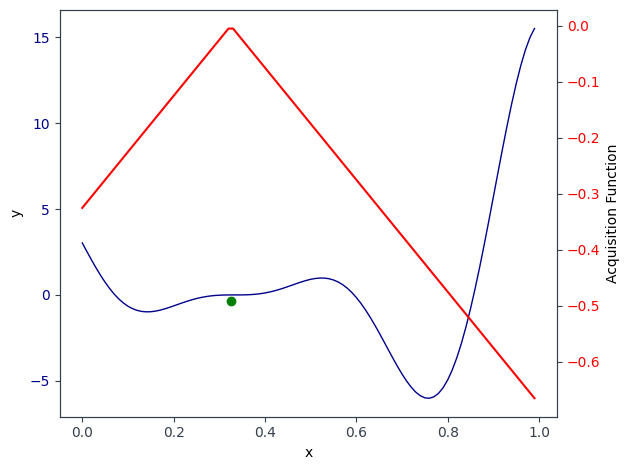

In [19]:
acq_data.plot_point()

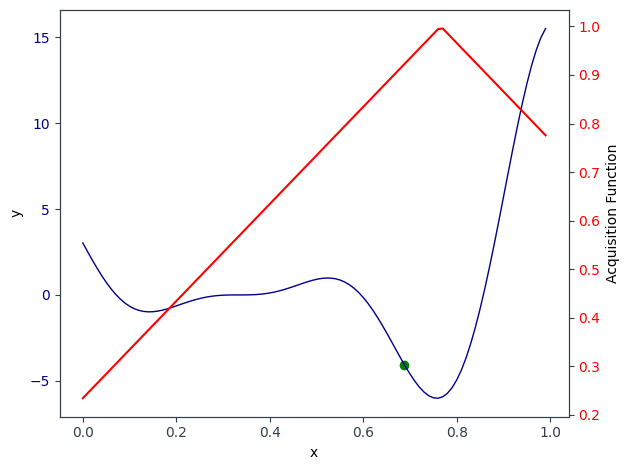

In [20]:
acq_data.plot_point(1)

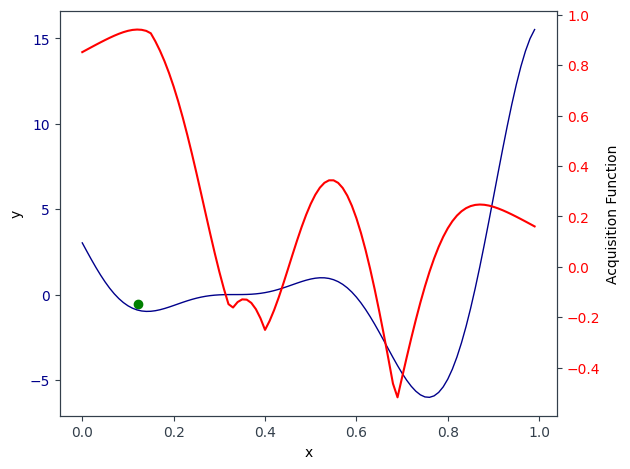

In [21]:
acq_data.plot_point(2)

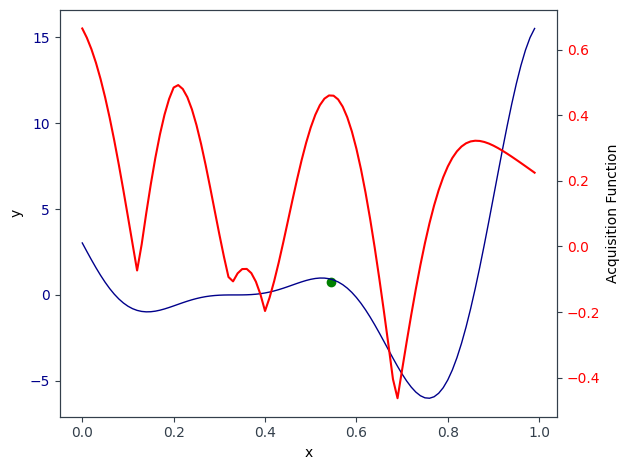

In [22]:
acq_data.plot_point(3)

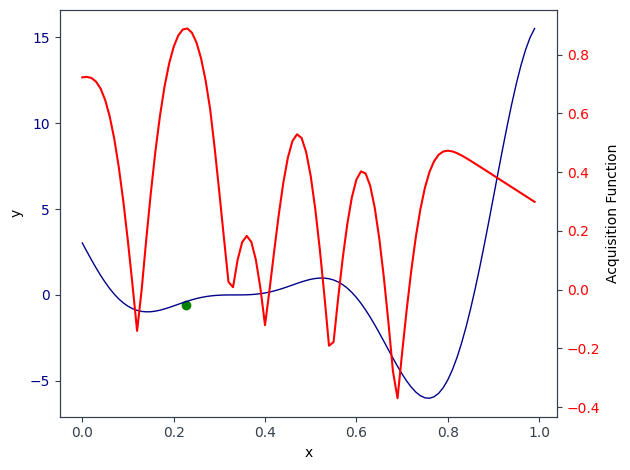

In [23]:
acq_data.plot_point(4)

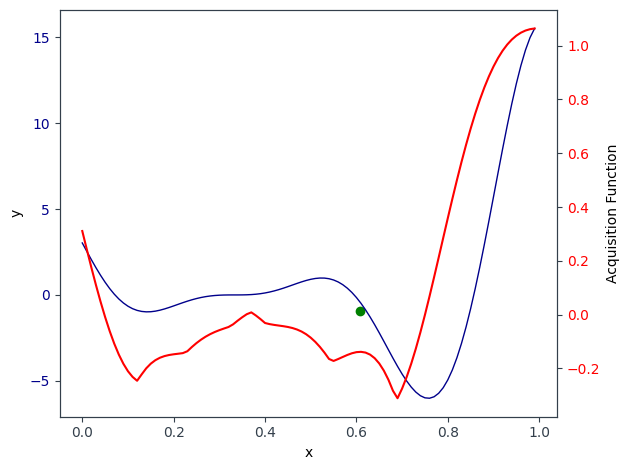

In [24]:
acq_data.plot_point(5)

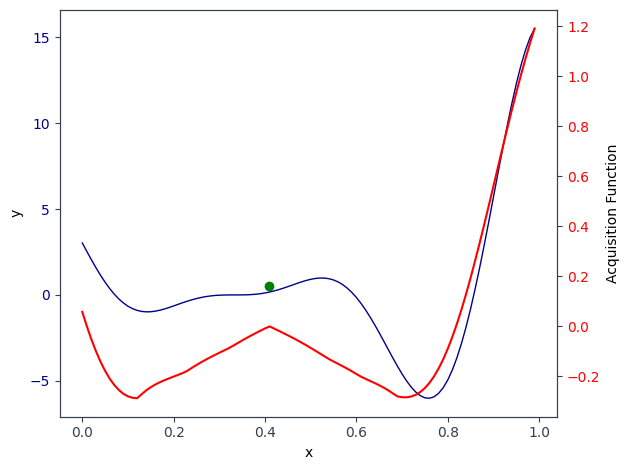

In [25]:
acq_data.plot_point(6)

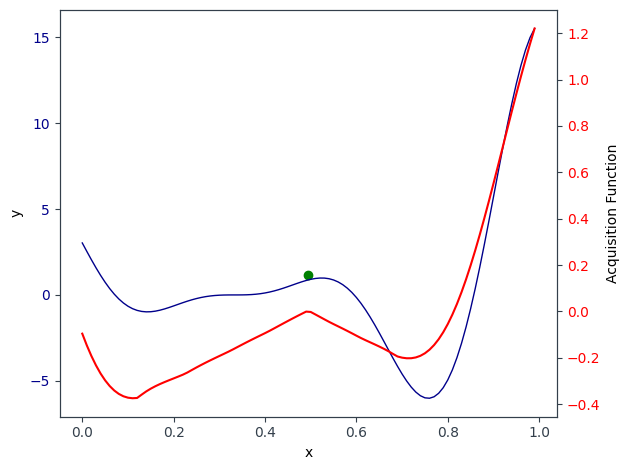

In [26]:
acq_data.plot_point(7)

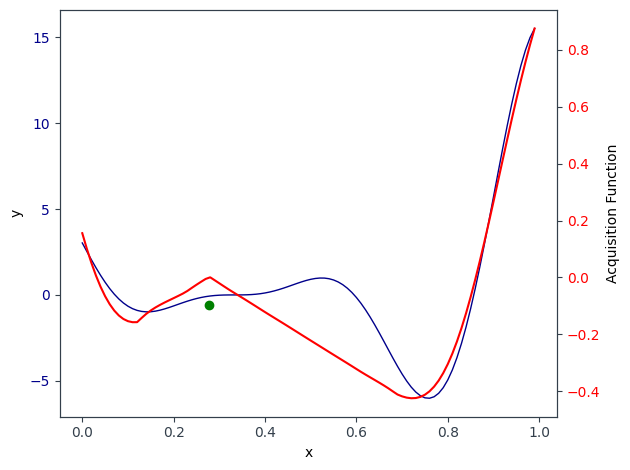

In [27]:
acq_data.plot_point(8)

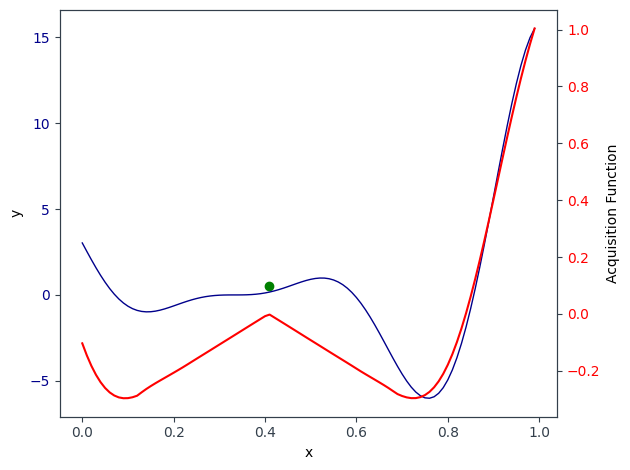

In [28]:
acq_data.plot_point(9)

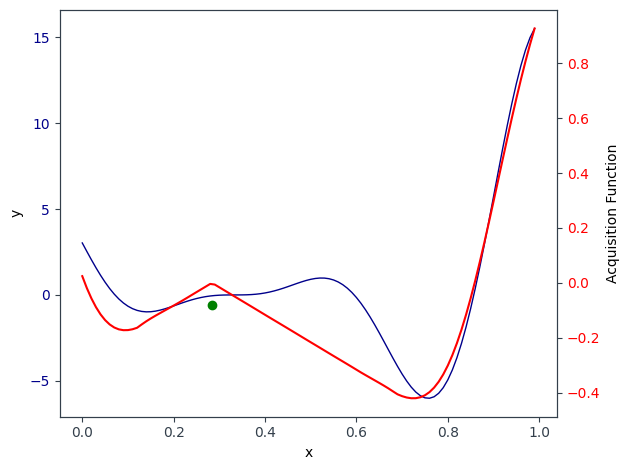

In [29]:
acq_data.plot_point(10)

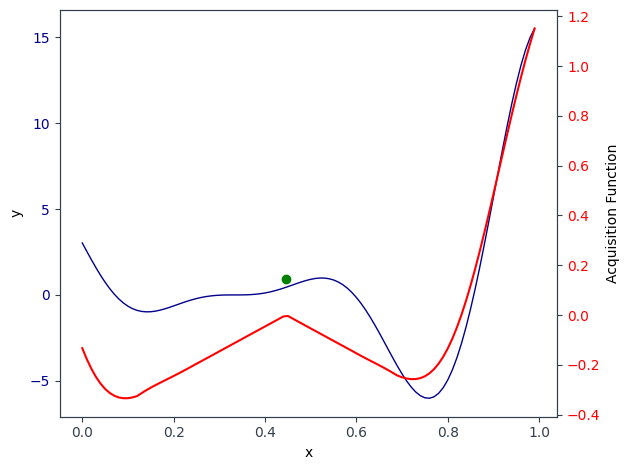

In [30]:
acq_data.plot_point(11)

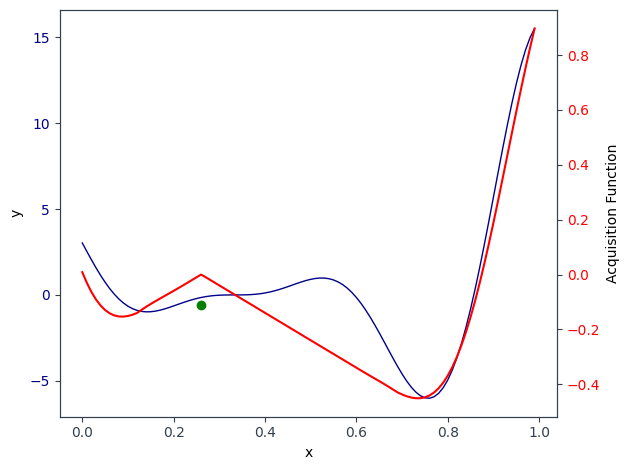

In [31]:
acq_data.plot_point(12)

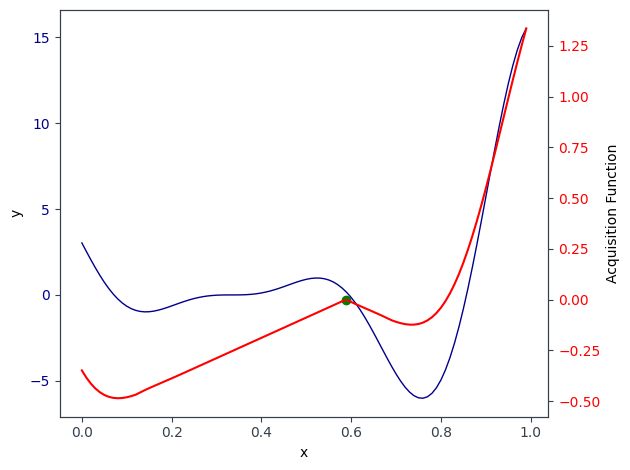

In [32]:
acq_data.plot_point(13)

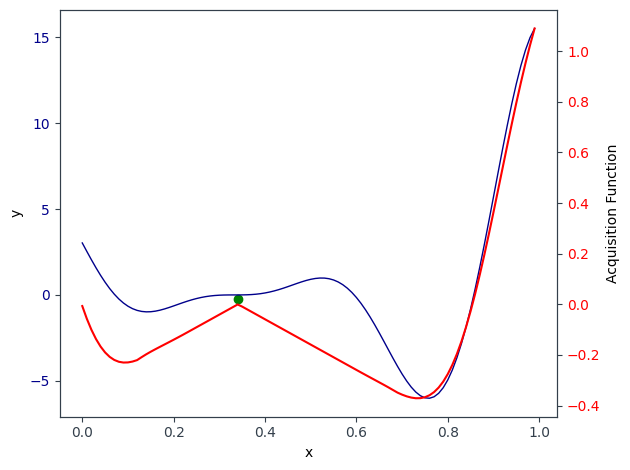

In [33]:
acq_data.plot_point(14)

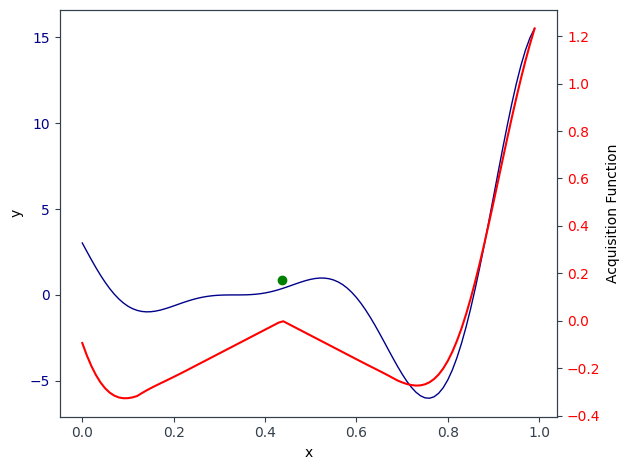

In [34]:
acq_data.plot_point(15)

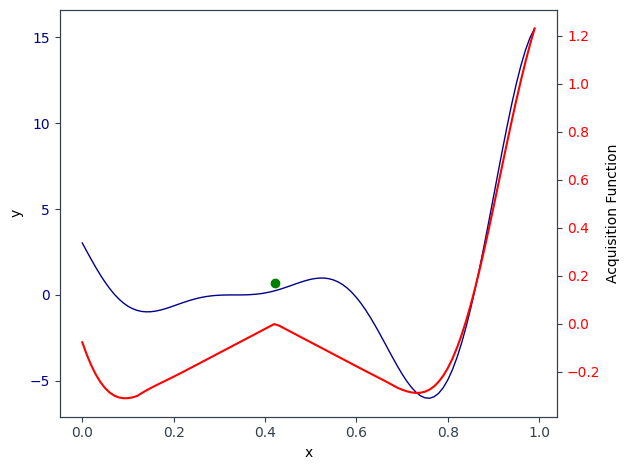

In [35]:
acq_data.plot_point(16)

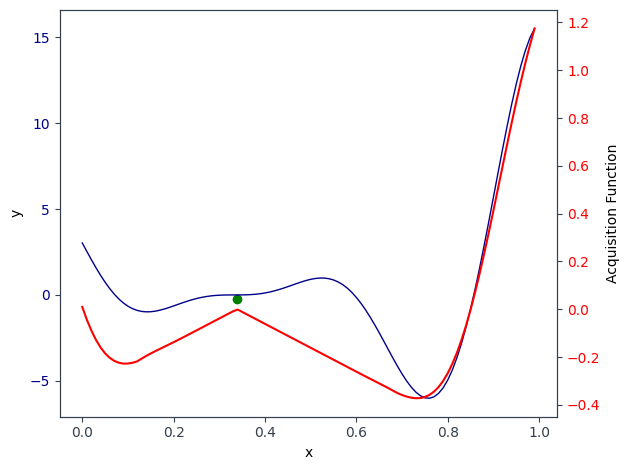

In [36]:
acq_data.plot_point(17)

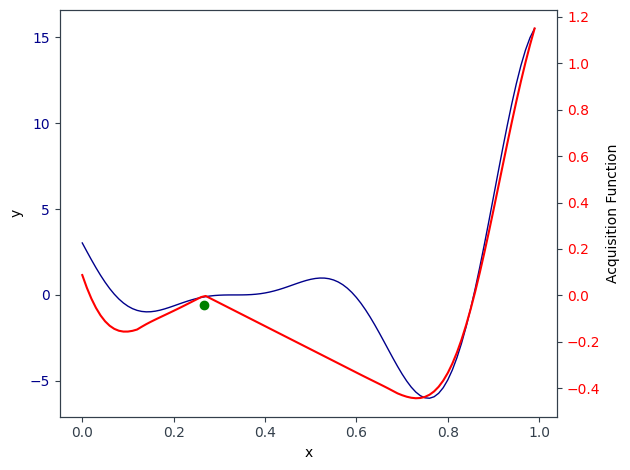

In [37]:
acq_data.plot_point(18)

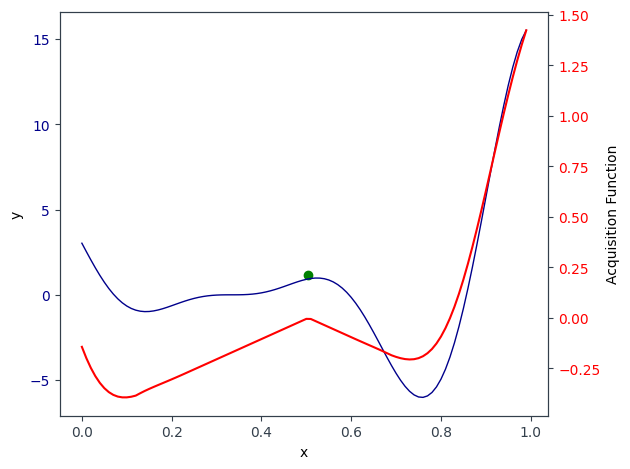

In [38]:
acq_data.plot_point(19)

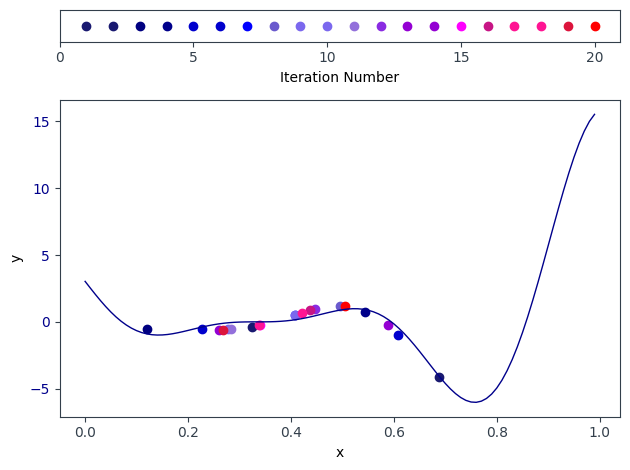

In [39]:
acq_data.plot_all()